In [0]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [0]:
import sys
sys.path.append("..")
import grading

In [0]:
import tensorflow as tf
import keras, keras.layers as L, keras.backend as K
import numpy as np
from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
import download_utils
import keras_utils
import numpy as np
from keras_utils import reset_tf_session

Using TensorFlow backend.


In [0]:
from lfw_dataset import load_lfw_dataset

# Load dataset
Dataset was downloaded for you. Relevant links (just in case):
- http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
- http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
- http://vis-www.cs.umass.edu/lfw/lfw.tgz

In [0]:
import numpy as np
import os
import cv2
import pandas as pd
import tarfile
import tqdm_utils


ATTRS_NAME = "lfw_attributes.txt"  # http://www.cs.columbia.edu/CAVE/databases/pubfig/download/lfw_attributes.txt
IMAGES_NAME = "lfw-deepfunneled.tgz"  # http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz
RAW_IMAGES_NAME = "lfw.tgz"  # http://vis-www.cs.umass.edu/lfw/lfw.tgz


def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img


def load_lfw_dataset(
        use_raw=False,
        dx=80, dy=80,
        dimx=45, dimy=45):

    # read attrs
    df_attrs = pd.read_csv(ATTRS_NAME, sep='\t')
    df_attrs.columns = list(df_attrs.columns)[0:]
    #df_attrs = df_attrs.drop("NaN", axis=1)
    print(df_attrs.columns)

    imgs_with_attrs = set(map(tuple, df_attrs[["person", "imagenum"]].values))

    # read photos
    all_photos = []
    photo_ids = []

    with tarfile.open(RAW_IMAGES_NAME if use_raw else IMAGES_NAME) as f:
        for m in tqdm_utils.tqdm_notebook_failsafe(f.getmembers()):
            if m.isfile() and m.name.endswith(".jpg"):
                # prepare image
                img = decode_image_from_raw_bytes(f.extractfile(m).read())
                img = img[dy:-dy, dx:-dx]
                img = cv2.resize(img, (dimx, dimy))
                # parse person
                fname = os.path.split(m.name)[-1]
                fname_splitted = fname[:-4].replace('_', ' ').split()
                person_id = ' '.join(fname_splitted[:-1])
                photo_number = int(fname_splitted[-1])
                if (person_id, photo_number) in imgs_with_attrs:
                    all_photos.append(img)
                    photo_ids.append({'person': person_id, 'imagenum': photo_number})

    photo_ids = pd.DataFrame(photo_ids)
    all_photos = np.stack(all_photos).astype('uint8')

    # preserve photo_ids order!
    all_attrs = photo_ids.merge(df_attrs, on=('person', 'imagenum')).drop(["person", "imagenum"], axis=1)

    return all_photos, all_attrs

In [0]:
# load images
X, attr = load_lfw_dataset(use_raw=True, dimx=32, dimy=32)

IMG_SHAPE = X.shape[1:]

# center images
X = X.astype('float32') / 255.0 - 0.5

# split
X_train, X_test = train_test_split(X, test_size=0.1, random_state=42)

Index(['person', 'imagenum', 'Male', 'Asian', 'White', 'Black', 'Baby',
       'Child', 'Youth', 'Middle Aged', 'Senior', 'Black Hair', 'Blond Hair',
       'Brown Hair', 'Bald', 'No Eyewear', 'Eyeglasses', 'Sunglasses',
       'Mustache', 'Smiling', 'Frowning', 'Chubby', 'Blurry', 'Harsh Lighting',
       'Flash', 'Soft Lighting', 'Outdoor', 'Curly Hair', 'Wavy Hair',
       'Straight Hair', 'Receding Hairline', 'Bangs', 'Sideburns',
       'Fully Visible Forehead', 'Partially Visible Forehead',
       'Obstructed Forehead', 'Bushy Eyebrows', 'Arched Eyebrows',
       'Narrow Eyes', 'Eyes Open', 'Big Nose', 'Pointy Nose', 'Big Lips',
       'Mouth Closed', 'Mouth Slightly Open', 'Mouth Wide Open',
       'Teeth Not Visible', 'No Beard', 'Goatee', 'Round Jaw', 'Double Chin',
       'Wearing Hat', 'Oval Face', 'Square Face', 'Round Face', 'Color Photo',
       'Posed Photo', 'Attractive Man', 'Attractive Woman', 'Indian',
       'Gray Hair', 'Bags Under Eyes', 'Heavy Makeup', 'Rosy Chee

In [0]:
def show_image(x):
    plt.imshow(np.clip(x + 0.5, 0, 1))

X shape: (13143, 32, 32, 3)


18995

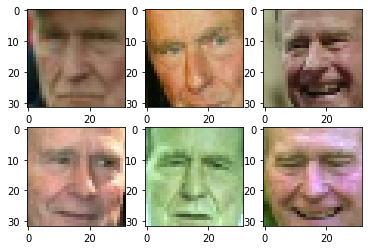

In [0]:
plt.title('sample images')

for i in range(6):
    plt.subplot(2,3,i+1)
    show_image(X[i])

print("X shape:", X.shape)
#print("attr shape:", attr.shape)

# try to free memory
del X
import gc
gc.collect()

In [0]:
def build_pca_autoencoder(img_shape, code_size):
    """
    Here we define a simple linear autoencoder as described above.
    We also flatten and un-flatten data to be compatible with image shapes
    """
    
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Flatten())                  #flatten image to vector
    encoder.add(L.Dense(code_size))           #actual encoder

    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(np.prod(img_shape)))  #actual decoder, height*width*3 units
    decoder.add(L.Reshape(img_shape))         #un-flatten
    
    return encoder,decoder

Meld them together into one model:

In [0]:
s = reset_tf_session()

encoder, decoder = build_pca_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer='adamax', loss='mse')

autoencoder.fit(x=X_train, y=X_train, epochs=15,
                validation_data=[X_test, X_test],
                callbacks=[keras_utils.TqdmProgressCallback()],
                verbose=0)




Instructions for updating:
If using Keras pass *_constraint arguments to layers.


Epoch 1/15




Epoch 2/15




Epoch 3/15




Epoch 4/15




Epoch 5/15




Epoch 6/15




Epoch 7/15




Epoch 8/15




Epoch 9/15




Epoch 10/15




Epoch 11/15




Epoch 12/15




Epoch 13/15




Epoch 14/15




Epoch 15/15


In [0]:
def visualize(img,encoder,decoder):
    """Draws original, encoded and decoded images"""
    code = encoder.predict(img[None])[0]  # img[None] is the same as img[np.newaxis, :]
    reco = decoder.predict(code[None])[0]

    plt.subplot(1,3,1)
    plt.title("Original")
    show_image(img)

    plt.subplot(1,3,2)
    plt.title("Code")
    plt.imshow(code.reshape([code.shape[-1]//2,-1]))

    plt.subplot(1,3,3)
    plt.title("Reconstructed")
    show_image(reco)
    plt.show()


PCA MSE: 0.006611854794785777


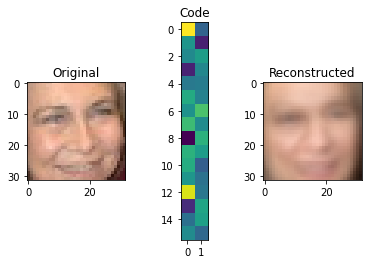

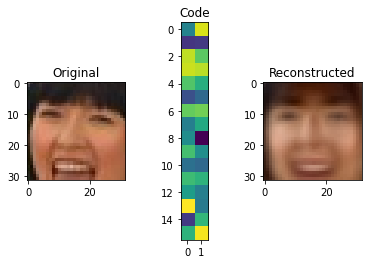

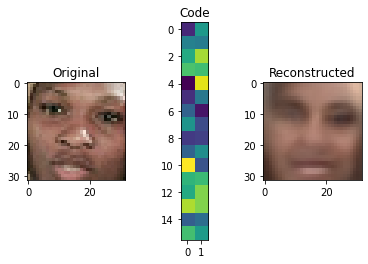

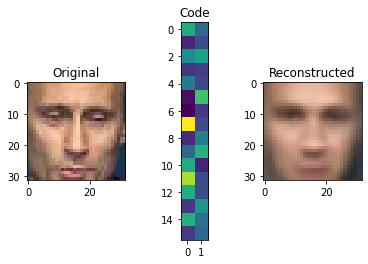

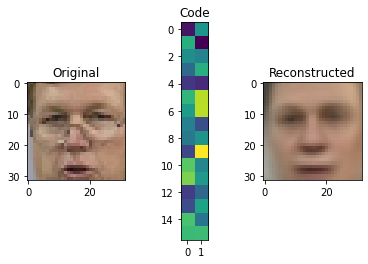

In [0]:
score = autoencoder.evaluate(X_test,X_test,verbose=0)
print("PCA MSE:", score)

for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [0]:
# Let's play around with transpose convolution on examples first
def test_conv2d_transpose(img_size, filter_size):
    print("Transpose convolution test for img_size={}, filter_size={}:".format(img_size, filter_size))
    
    x = (np.arange(img_size ** 2, dtype=np.float32) + 1).reshape((1, img_size, img_size, 1))
    f = (np.ones(filter_size ** 2, dtype=np.float32)).reshape((filter_size, filter_size, 1, 1))

    s = reset_tf_session()
    
    conv = tf.nn.conv2d_transpose(x, f, 
                                  output_shape=(1, img_size * 2, img_size * 2, 1), 
                                  strides=[1, 2, 2, 1], 
                                  padding='SAME')

    result = s.run(conv)
    print("input:")
    print(x[0, :, :, 0])
    print("filter:")
    print(f[:, :, 0, 0])
    print("output:")
    print(result[0, :, :, 0])
    s.close()
        
test_conv2d_transpose(img_size=2, filter_size=2)
test_conv2d_transpose(img_size=2, filter_size=3)
test_conv2d_transpose(img_size=4, filter_size=2)
test_conv2d_transpose(img_size=4, filter_size=3)

Transpose convolution test for img_size=2, filter_size=2:
input:
[[1. 2.]
 [3. 4.]]
filter:
[[1. 1.]
 [1. 1.]]
output:
[[1. 1. 2. 2.]
 [1. 1. 2. 2.]
 [3. 3. 4. 4.]
 [3. 3. 4. 4.]]
Transpose convolution test for img_size=2, filter_size=3:
input:
[[1. 2.]
 [3. 4.]]
filter:
[[1. 1. 1.]
 [1. 1. 1.]
 [1. 1. 1.]]
output:
[[ 1.  1.  3.  2.]
 [ 1.  1.  3.  2.]
 [ 4.  4. 10.  6.]
 [ 3.  3.  7.  4.]]
Transpose convolution test for img_size=4, filter_size=2:
input:
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]]
filter:
[[1. 1.]
 [1. 1.]]
output:
[[ 1.  1.  2.  2.  3.  3.  4.  4.]
 [ 1.  1.  2.  2.  3.  3.  4.  4.]
 [ 5.  5.  6.  6.  7.  7.  8.  8.]
 [ 5.  5.  6.  6.  7.  7.  8.  8.]
 [ 9.  9. 10. 10. 11. 11. 12. 12.]
 [ 9.  9. 10. 10. 11. 11. 12. 12.]
 [13. 13. 14. 14. 15. 15. 16. 16.]
 [13. 13. 14. 14. 15. 15. 16. 16.]]
Transpose convolution test for img_size=4, filter_size=3:
input:
[[ 1.  2.  3.  4.]
 [ 5.  6.  7.  8.]
 [ 9. 10. 11. 12.]
 [13. 14. 15. 16.]]
filter

In [0]:
def build_deep_autoencoder(img_shape, code_size):
    """PCA's deeper brother. See instructions above. Use `code_size` in layer definitions."""
    H,W,C = img_shape
    
    # encoder
    encoder = keras.models.Sequential()
    encoder.add(L.InputLayer(img_shape))
    encoder.add(L.Conv2D(filters = 32, kernel_size = (3,3), strides=1, padding='same' ,activation='elu'))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters = 64, kernel_size = (3,3), strides=1, padding='same',activation='elu')) 
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters = 128, kernel_size = (3,3), strides=1, padding='same',activation='elu' ))
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Conv2D(filters = 256, kernel_size = (3,3), strides=1, padding='same',activation='elu')) 
    encoder.add(L.MaxPooling2D(pool_size=(2, 2)))
    encoder.add(L.Flatten())
    encoder.add(L.Dense(code_size))
    encoder.summary()
    
    ### YOUR CODE HERE: define encoder as per instructions above ###

    # decoder
    decoder = keras.models.Sequential()
    decoder.add(L.InputLayer((code_size,)))
    decoder.add(L.Dense(1024))
    decoder.add(L.Reshape((2,2,256)))
    decoder.add(L.Conv2DTranspose(filters=128, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=64, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=32, kernel_size=(3, 3), strides=2, activation='elu', padding='same'))
    decoder.add(L.Conv2DTranspose(filters=3, kernel_size=(3, 3), strides=2, activation=None, padding='same'))
    decoder.summary()
    return encoder, decoder

In [0]:
# Check autoencoder shapes along different code_sizes
get_dim = lambda layer: np.prod(layer.output_shape[1:])
for code_size in [1,8,32,128,512]:
    s = reset_tf_session()
    encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=code_size)
    print("Testing code size %i" % code_size)
    assert encoder.output_shape[1:]==(code_size,),"encoder must output a code of required size"
    assert decoder.output_shape[1:]==IMG_SHAPE,   "decoder must output an image of valid shape"
    assert len(encoder.trainable_weights)>=6,     "encoder must contain at least 3 layers"
    assert len(decoder.trainable_weights)>=6,     "decoder must contain at least 3 layers"
    
    for layer in encoder.layers + decoder.layers:
        assert get_dim(layer) >= code_size, "Encoder layer %s is smaller than bottleneck (%i units)"%(layer.name,get_dim(layer))

print("All tests passed!")
s = reset_tf_session()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)        

In [0]:
# Look at encoder and decoder shapes.
# Total number of trainable parameters of encoder and decoder should be close.
s = reset_tf_session()
encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.summary()
decoder.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)        

Convolutional autoencoder training. This will take **1 hour**. You're aiming at ~0.0056 validation MSE and ~0.0054 training MSE.

In [0]:
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)        

In [0]:
# we will save model checkpoints here to continue training in case of kernel death
model_filename = 'autoencoder.{0:03d}.hdf5'
last_finished_epoch = None

#### uncomment below to continue training from model checkpoint
#### fill `last_finished_epoch` with your latest finished epoch
# from keras.models import load_model
# s = reset_tf_session()
# last_finished_epoch = 4
# autoencoder = load_model(model_filename.format(last_finished_epoch))
# encoder = autoencoder.layers[1]
# decoder = autoencoder.layers[2]

In [0]:
autoencoder.fit(x=X_train, y=X_train, epochs=25,
                validation_data=[X_test, X_test],
                callbacks=[keras_utils.ModelSaveCallback(model_filename),
                           keras_utils.TqdmProgressCallback()],
                verbose=0,
                initial_epoch=last_finished_epoch or 0)


Epoch 1/25


Model saved in autoencoder.000.hdf5


Epoch 2/25


Model saved in autoencoder.001.hdf5


Epoch 3/25


Model saved in autoencoder.002.hdf5


Epoch 4/25


Model saved in autoencoder.003.hdf5


Epoch 5/25


Model saved in autoencoder.004.hdf5


Epoch 6/25


Model saved in autoencoder.005.hdf5


Epoch 7/25


Model saved in autoencoder.006.hdf5


Epoch 8/25


Model saved in autoencoder.007.hdf5


Epoch 9/25


Model saved in autoencoder.008.hdf5


Epoch 10/25


Model saved in autoencoder.009.hdf5


Epoch 11/25


Model saved in autoencoder.010.hdf5


Epoch 12/25


Model saved in autoencoder.011.hdf5


Epoch 13/25


Model saved in autoencoder.012.hdf5


Epoch 14/25


Model saved in autoencoder.013.hdf5


Epoch 15/25


Model saved in autoencoder.014.hdf5


Epoch 16/25


Model saved in autoencoder.015.hdf5


Epoch 17/25


Model saved in autoencoder.016.hdf5


Epoch 18/25


Model saved in autoencoder.017.hdf5


Epoch 19/25


Model saved in autoencoder.018.hdf5


Epoch 20/25


Model saved in autoencoder.019.hdf5


Epoch 21/25


Model saved in autoencoder.020.hdf5


Epoch 22/25


Model saved in autoencoder.021.hdf5


Epoch 23/25


Model saved in autoencoder.022.hdf5


Epoch 24/25


Model saved in autoencoder.023.hdf5


Epoch 25/25


Model saved in autoencoder.024.hdf5



Convolutional autoencoder MSE: 0.00542526996407672


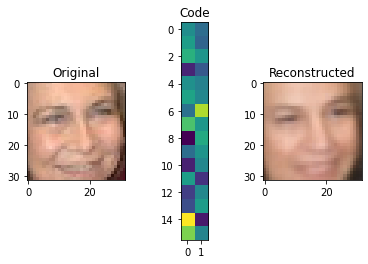

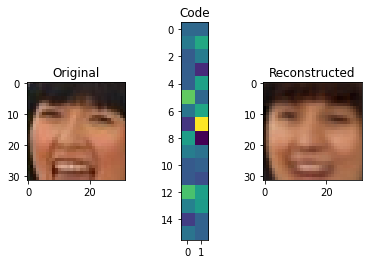

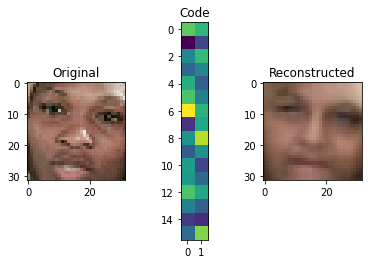

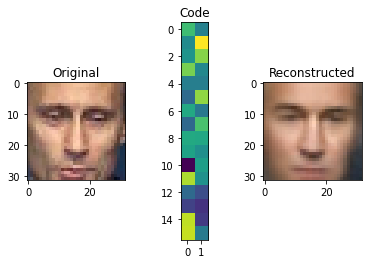

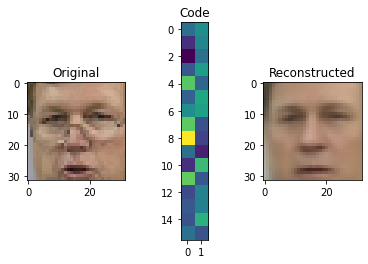

In [0]:
reconstruction_mse = autoencoder.evaluate(X_test, X_test, verbose=0)
print("Convolutional autoencoder MSE:", reconstruction_mse)
for i in range(5):
    img = X_test[i]
    visualize(img,encoder,decoder)

In [0]:
# save trained weights
encoder.save_weights("encoder.h5")
decoder.save_weights("decoder.h5")

In [0]:
# restore trained weights
s = reset_tf_session()

encoder, decoder = build_deep_autoencoder(IMG_SHAPE, code_size=32)
encoder.load_weights("encoder.h5")
decoder.load_weights("decoder.h5")

inp = L.Input(IMG_SHAPE)
code = encoder(inp)
reconstruction = decoder(code)

autoencoder = keras.models.Model(inputs=inp, outputs=reconstruction)
autoencoder.compile(optimizer="adamax", loss='mse')

print(autoencoder.evaluate(X_test, X_test, verbose=0))
print(reconstruction_mse)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 4, 4, 128)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 4, 4, 256)        